In [ ]:
# Written by Rikard Forlin
# rikard.forlin@ki.se

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy
import scipy.stats as stats
from matplotlib import rcParams



# Hallmarks

In [2]:
hallmark_ifna = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "IRF7", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]

hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]

# Pathways to data:

## Download data and insert your pathways here:

In [2]:
r848_v1_path = 'insert datapath here to ./scRNAseq_data/r848_v1.h5ad'
r848_v2_path = 'insert datapath here to ./scRNAseq_data/r848_v2.h5ad'

ntc_v1_path = 'insert datapath here to ./scRNAseq_data/ntc_v1.h5ad'
ntc_v2_path = 'insert datapath here to ./scRNAseq_data/ntc_v2.h5ad'

lps_v1_path = 'insert datapath here to ./scRNAseq_data/lps_v1.h5ad'
lps_v2_path = 'insert datapath here to ./scRNAseq_data/lps_v2.h5ad'

# Figure 2h - R848 stim pDC barplots

In [4]:
r848_v1 = sc.read_h5ad(r848_v1_path)
r848_v2 = sc.read_h5ad(r848_v2_path)

sc.pp.normalize_total(r848_v1, target_sum=1e4)
sc.pp.normalize_total(r848_v2, target_sum=1e4)

ct = 'pDC'
stim_v1 = r848_v1[r848_v1.obs.CellType == ct].to_df() 
stim_v2 = r848_v2[r848_v2.obs.CellType == ct].to_df()


In [5]:
inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})

#btm_annotation table from Li et al: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3946932/
btm = pd.read_csv('../../btm_annotation_table.csv', sep = ';')
btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]
btm_file = pd.concat([btm, inhouse_btms])



In [6]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

genes_included = pd.DataFrame(columns = ['Module', 'Genes'])

#Calculate median of BTM-sum
for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Take median of BTM-sum
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
        genes_included = pd.concat([genes_included, pd.DataFrame({'Module': btm_file.iloc[j, 0], 'Composite Name':btm_file.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0])])
        
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
genes_included = genes_included.drop_duplicates(subset = 'Module')

In [7]:
btms_v1 = dfs_btm[0].T.reset_index()
btms_v2 = dfs_btm[1].T.reset_index()

btms_v1.columns = ['module', 'sum']
btms_v2.columns = ['module', 'sum']

df_btm_v1 = pd.DataFrame({'module':btms_v1['module'], 'stim_values':btms_v1['sum'], 'V':'V1'})
df_btm_v2 = pd.DataFrame({'module':btms_v2['module'], 'stim_values':btms_v2['sum'], 'V':'V2'})

In [8]:
#Make barplot df and plot the barplot with the modules we want:
barplot_df = pd.concat([df_btm_v1, df_btm_v2])
modules = ['M5.0', 'M11.0', 'M71', 'M75', 'M111.1', 'M121', 'M127', 'M146', 'S5', 'Hallmark IFNa', 'Hallmark TNF']
barplot_df = barplot_df[barplot_df.module.isin(modules)]

Text(0.5, 1.0, 'pDC - R848 V1 and V2')

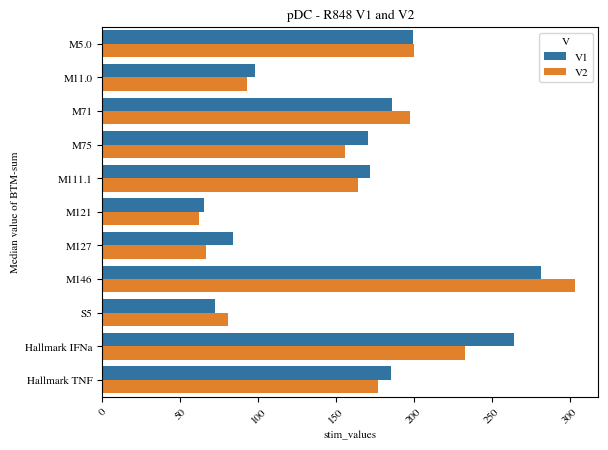

In [9]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df, hue = 'V')
plt.xticks(rotation = 45)
plt.ylabel('Median value of BTM-sum')
plt.title('pDC - R848 V1 and V2')
#plt.savefig('figures/Figure2/pDC_r848_BTMbarplots.svg')

### Calculate p-values for R848-stim pDC


In [10]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Summarize BTMs for all cells
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1).values})
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
        


In [11]:
btms_v1 = dfs_btm[0]
btms_v2 = dfs_btm[1]

In [15]:
pdc_r848_t_test = pd.DataFrame()
for m in modules:
    t_statistic, pvalue = stats.ttest_ind(a=np.log1p(btms_v1[m]), b=np.log1p(btms_v2[m]))
    temp = pd.DataFrame({'t_statistic': t_statistic, 'pvalue':pvalue}, index=[m])
    pdc_r848_t_test = pd.concat([pdc_r848_t_test, temp])

In [16]:
pdc_r848_t_test

,t_statistc,pvalue
M5.0,-0.426405,0.670878
M11.0,0.641977,0.522596
M71,-0.546615,0.586059
M75,1.641239,0.104400
M111.1,1.668578,0.098838
M121,0.211750,0.832803
M127,2.294387,0.024205
M146,-0.312986,0.755049
S5,-2.231262,0.028265
Hallmark IFNa,3.076256,0.002811


# Figure 2g - violin plots for ISG20, PARP14, SP110 and MX1

In [18]:
r8_v1 = sc.read_h5ad(r848_v1_path)
ntc_v1 = sc.read_h5ad(ntc_v1_path)

r8_v2 = sc.read_h5ad(r848_v2_path)
ntc_v2 = sc.read_h5ad(ntc_v2_path)

sc.pp.normalize_total(r8_v1, target_sum=1e4)
sc.pp.normalize_total(r8_v2, target_sum=1e4)
sc.pp.normalize_total(ntc_v1, target_sum=1e4)
sc.pp.normalize_total(ntc_v2, target_sum=1e4)



In [19]:
ct = 'pDC'
stim_v1 = r8_v1[r8_v1.obs.CellType == ct].to_df() 
stim_v2 = r8_v2[r8_v2.obs.CellType == ct].to_df() 

notstim_v1 = ntc_v1[ntc_v1.obs.CellType == ct].to_df()
notstim_v2 = ntc_v2[ntc_v2.obs.CellType == ct].to_df()


In [20]:
#Make sure columns are aligned within the two countmatrices
stim_v1 = stim_v1.groupby(axis=1, level=0).sum()
stim_v2 = stim_v2.groupby(axis=1, level=0).sum()
stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

In [21]:
#Calculate median of the unstim - to normalise the stimulated data from
ntcmedian_v1 = notstim_v1.median()
ntcmedian_v2 = notstim_v2.median()

ntcmedian_v1 = ntcmedian_v1[ntcmedian_v1.index.isin(stim_v1.columns)]
ntcmedian_v2 = ntcmedian_v2[ntcmedian_v2.index.isin(stim_v2.columns)]

stim_v1_sub = stim_v1[ntcmedian_v1.index]
stim_v2_sub = stim_v2[ntcmedian_v2.index]

In [22]:
#Normalizing by subtracting median sum
stim_v1_sub = stim_v1_sub - ntcmedian_v1
stim_v2_sub = stim_v2_sub - ntcmedian_v2

In [23]:
#gene markers to look at:
markers = ['ISG20', 'MX1', 'PARP14', 'SP110']

#Create violinplot
violin_df = pd.DataFrame()
for m in markers:
    temp1 = pd.DataFrame({'value': stim_v1_sub[m], 'gene':m, 'V':'V1'})
    temp2 = pd.DataFrame({'value': stim_v2_sub[m], 'gene':m, 'V':'V2'})
    both = pd.concat([temp2, temp1])
    violin_df = pd.concat([both, violin_df])
violin_df = violin_df.sort_values(by = 'gene')

<AxesSubplot: xlabel='gene', ylabel='value'>

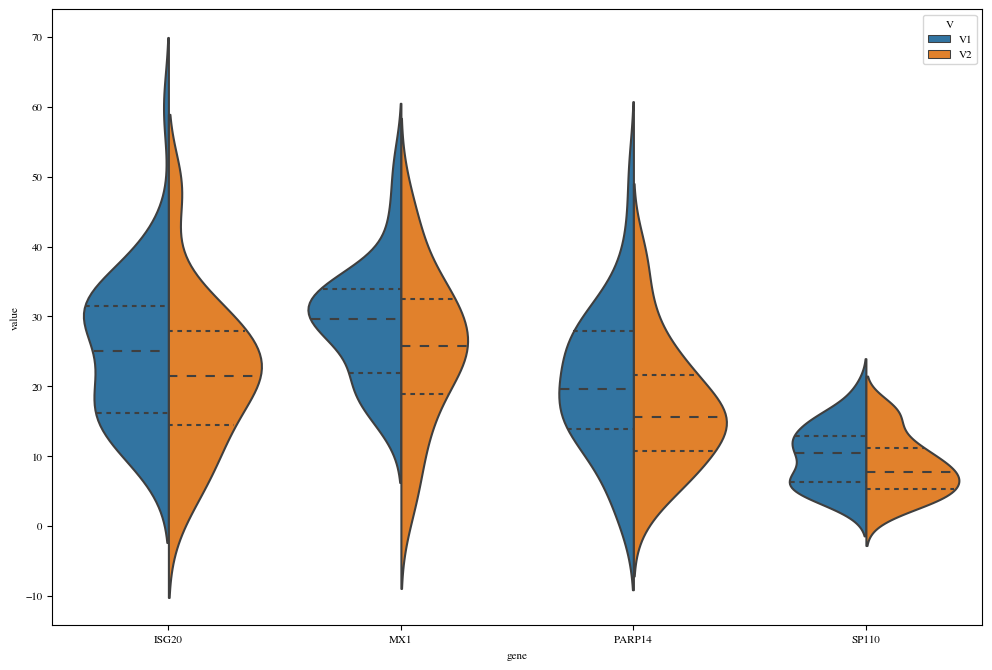

In [24]:
plt.figure(figsize = (12,8))
sns.violinplot(x = 'gene', y = 'value', hue = 'V', data = violin_df, inner = 'quartile', split = True)

#plt.savefig('figures/Figure2/pDC_r848_violinplots_genes.svg')

### pvalues for violin plots:

In [25]:
gene ='SP110'
scipy.stats.ttest_ind(np.log1p(violin_df[(violin_df.gene == gene) & (violin_df.V == 'V1')]['value']), np.log1p(violin_df[(violin_df.gene == gene) & (violin_df.V == 'V2')]['value']))

Ttest_indResult(statistic=1.6443352299717358, pvalue=0.10375781126774122)

In [26]:
gene ='ISG20'
scipy.stats.ttest_ind(np.log1p(violin_df[(violin_df.gene == gene) & (violin_df.V == 'V1')]['value']), np.log1p(violin_df[(violin_df.gene == gene) & (violin_df.V == 'V2')]['value']))

Ttest_indResult(statistic=1.7282632175415524, pvalue=0.08753003023895485)

In [27]:
gene ='MX1'
scipy.stats.ttest_ind(np.log1p(violin_df[(violin_df.gene == gene) & (violin_df.V == 'V1')]['value']), np.log1p(violin_df[(violin_df.gene == gene) & (violin_df.V == 'V2')]['value']))

Ttest_indResult(statistic=2.299716609169034, pvalue=0.023886592492148626)

In [28]:
gene ='PARP14'
scipy.stats.ttest_ind(np.log1p(violin_df[(violin_df.gene == gene) & (violin_df.V == 'V1')]['value']), np.log1p(violin_df[(violin_df.gene == gene) & (violin_df.V == 'V2')]['value']))

Ttest_indResult(statistic=1.291488270685561, pvalue=0.19999479097366873)

# Figure 2j and 2k - dotplots with linear regression

In [30]:
#Recreate hallmark_ifna but no IRF7 (IRF7 included in original hallmark_ifna)
hallmark_ifna_noirf7 = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]



In [31]:
r848_v1 = sc.read(r848_v1_path)
r848_v2 = sc.read(r848_v2_path)

sc.pp.normalize_total(r848_v1, target_sum = 1e4)
sc.pp.normalize_total(r848_v2, target_sum = 1e4)

pdc_v1 = r848_v1[r848_v1.obs.CellType == 'pDC'].to_df()
pdc_v2 = r848_v2[r848_v2.obs.CellType == 'pDC'].to_df()

sum_v1 = np.sum(pdc_v1[hallmark_ifna_noirf7], axis = 1)
sum_v2 = np.sum(pdc_v2[hallmark_ifna_noirf7], axis = 1)

In [32]:
v1_scat = pd.DataFrame({'hallmark':sum_v1, 'IRF7':pdc_v1['IRF7'], 'SOCS3':pdc_v1['SOCS3'], 'V': 'V1'})
v2_scat = pd.DataFrame({'hallmark':sum_v2, 'IRF7':pdc_v2['IRF7'], 'SOCS3':pdc_v2['SOCS3'], 'V': 'V2'})

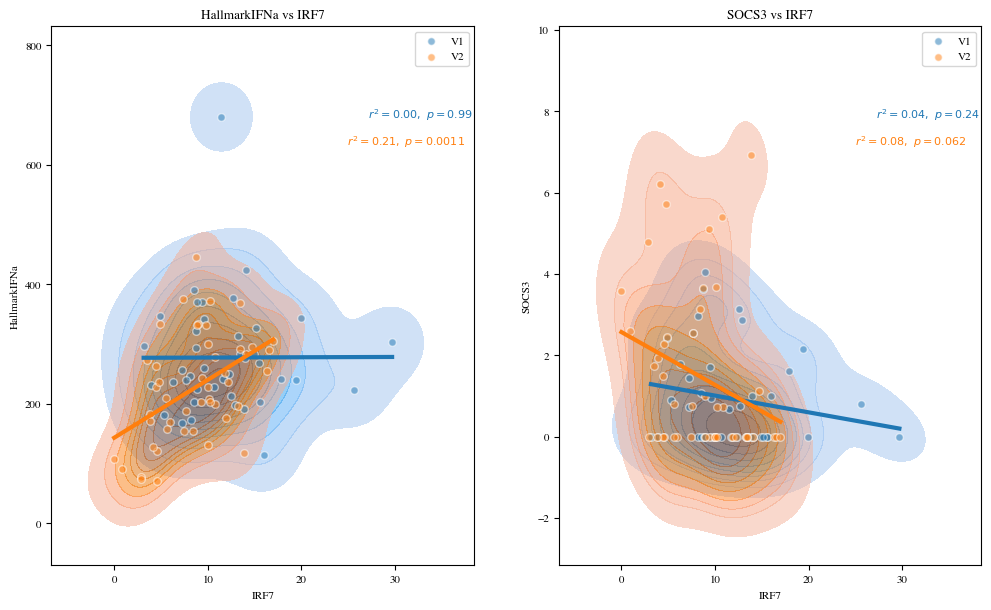

In [34]:


fig, ax = plt.subplots(1,2, figsize = (12,7))
genex = 'IRF7'
geney = 'hallmark'
sns.kdeplot(x=genex, y=geney, data=v1_scat, fill=True, ax=ax[0], alpha = 0.5)
sns.kdeplot(x=genex, y=geney, data=v2_scat, fill=True, ax=ax[0], alpha = 0.5)
sns.regplot(x=genex, y=geney, data=v1_scat, fit_reg=True, ci=None, ax=ax[0], label='V1', scatter_kws=dict(alpha=0.5, s=30, edgecolors='white'),line_kws=dict(alpha=1, linewidth=3))
sns.regplot(x=genex, y=geney, data=v2_scat, fit_reg=True, ci=None, ax=ax[0], label='V2', scatter_kws=dict(alpha=0.5, s=30, edgecolors='white'),line_kws=dict(alpha=1, linewidth=3))
slope, intercept, r_value_v1, p_value_v1, std_err = scipy.stats.linregress(v1_scat[genex], v1_scat[geney])
slope, intercept, r_value_v2, p_value_v2, std_err = scipy.stats.linregress(v2_scat[genex], v2_scat[geney])
text1 = r'$r^2={:.2f},\ p={:.2g}$'.format(r_value_v1 ** 2, p_value_v1)
text2 = r'$r^2={:.2f},\ p={:.2g}$'.format(r_value_v2 ** 2, p_value_v2)
ax[0].text(.75, .83, text1, transform=ax[0].transAxes, color = sns.color_palette()[0])
ax[0].text(.7, .78, text2, transform=ax[0].transAxes, color = sns.color_palette()[1])
ax[0].set(ylabel='HallmarkIFNa', xlabel=genex)
ax[0].set_title('HallmarkIFNa vs ' + genex)
ax[0].legend()

genex = 'IRF7'
geney = 'SOCS3'
sns.kdeplot(x=genex, y=geney, data=v1_scat, fill=True, ax=ax[1], alpha = 0.5)
sns.kdeplot(x=genex, y=geney, data=v2_scat, fill=True, ax=ax[1], alpha = 0.5)
sns.regplot(x=genex, y=geney, data=v1_scat, fit_reg=True, ci=None, ax=ax[1], label='V1', scatter_kws=dict(alpha=0.5, s=30, edgecolors='white'),line_kws=dict(alpha=1, linewidth=3))
sns.regplot(x=genex, y=geney, data=v2_scat, fit_reg=True, ci=None, ax=ax[1], label='V2', scatter_kws=dict(alpha=0.5, s=30, edgecolors='white'),line_kws=dict(alpha=1, linewidth=3))
slope, intercept, r_value_v1, p_value_v1, std_err = scipy.stats.linregress(v1_scat[genex], v1_scat[geney])
slope, intercept, r_value_v2, p_value_v2, std_err = scipy.stats.linregress(v2_scat[genex], v2_scat[geney])
text1 = r'$r^2={:.2f},\ p={:.2g}$'.format(r_value_v1 ** 2, p_value_v1)
text2 = r'$r^2={:.2f},\ p={:.2g}$'.format(r_value_v2 ** 2, p_value_v2)
ax[1].text(.75, .83, text1, transform=ax[1].transAxes, color = sns.color_palette()[0])
ax[1].text(.7, .78, text2, transform=ax[1].transAxes, color = sns.color_palette()[1])
ax[1].set(ylabel=geney, xlabel=genex)
ax[1].set_title('SOCS3 vs ' + genex) 
ax[1].legend()
